In [4]:
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import mediapipe as mp

# --- Load Model and Label Encoder ---
model = load_model("asl_cnn_2D_model.h5")
with open("label_encoder.pickle", "rb") as f:
    label_encoder = pickle.load(f)

# --- Rebuild Test Data from Scratch ---
data_dir = 'ASL_Alphabet_Dataset/asl_alphabet_train'

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.6)

data = []
labels = []

print("🔄 Rebuilding dataset...")
for label in sorted(os.listdir(data_dir)):
    if label == '.DS_Store':
        continue

    label_path = os.path.join(data_dir, label)
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                landmark_data = []
                for point in hand_landmarks.landmark:
                    landmark_data.append(point.x)
                    landmark_data.append(point.y)
                data.append(landmark_data)
                labels.append(label)

print("✅ Landmark extraction done.")



🔄 Rebuilding dataset...
✅ Landmark extraction done.


In [12]:
import pickle

# Load the pickled model (RCF / MLP / sklearn / Keras Sequential)
with open("model.p", "rb") as f:
    model_dict = pickle.load(f)
    model = model_dict["model"]  # or the key you used when saving
# Convert to arrays
# Filter out samples with labels not present in label_encoder
filtered_data = []
filtered_labels = []

for d, l in zip(data, labels):
    if l in label_encoder.classes_:
        filtered_data.append(d)
        filtered_labels.append(l)
    else:
        print(f"⚠️ Skipping unknown label: {l}")

data = np.array(filtered_data)
labels = np.array(filtered_labels)

print("📦 Unique labels found in dataset:", set(labels))
print("📜 Labels known to label_encoder:", label_encoder.classes_)

# Encode labels
labels_encoded = label_encoder.transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split again (using same split ratio)
X_train, X_test, y_train, y_test = train_test_split(
    data, labels_categorical, test_size=0.15, random_state=22, shuffle=True
)


# --- Predict and Evaluate ---
y_pred = model.predict(X_test)  # Already label strings
y_true = label_encoder.inverse_transform(np.argmax(y_test, axis=1))


# Use predictions directly (no inverse_transform needed)
y_pred_labels = y_pred
y_true_labels = y_true




📦 Unique labels found in dataset: {'E', 'L', 'C', 'V', 'D', 'N', 'M', 'S', 'G', 'R', 'space', 'Y', 'K', 'X', 'del', 'B', 'O', 'U', 'Z', 'A', 'T', 'F', 'W', 'J', 'H', 'P', 'Q', 'I'}
📜 Labels known to label_encoder: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'del' 'space']


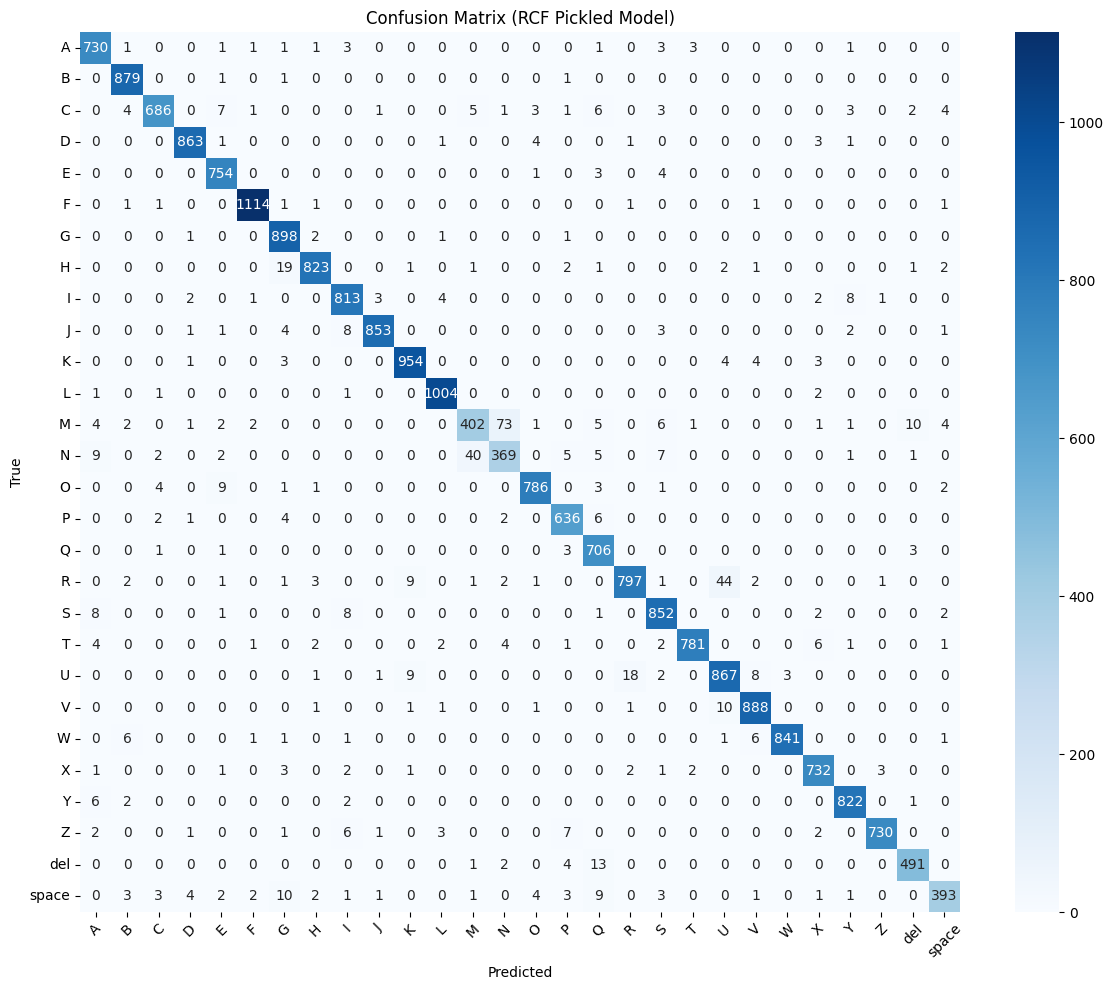


📋 Classification Report:
              precision    recall  f1-score   support

           A       0.95      0.98      0.97       746
           B       0.98      1.00      0.99       882
           C       0.98      0.94      0.96       727
           D       0.99      0.99      0.99       874
           E       0.96      0.99      0.98       762
           F       0.99      0.99      0.99      1121
           G       0.95      0.99      0.97       903
           H       0.98      0.96      0.97       853
           I       0.96      0.97      0.97       834
           J       0.99      0.98      0.98       873
           K       0.98      0.98      0.98       969
           L       0.99      1.00      0.99      1009
           M       0.89      0.78      0.83       515
           N       0.81      0.84      0.83       441
           O       0.98      0.97      0.98       807
           P       0.96      0.98      0.97       651
           Q       0.93      0.99      0.96       714
 

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (RCF Pickled Model)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, labels=label_encoder.classes_))